# Wczytanie danych

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lux

In [44]:
df = pd.read_csv("../Data/data_for_presentation.xz", compression="xz")

/home/pk/miniconda3/envs/Hackathon-2021-RTFD/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [45]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

# Analiza danych

## Korelogram

<AxesSubplot:>

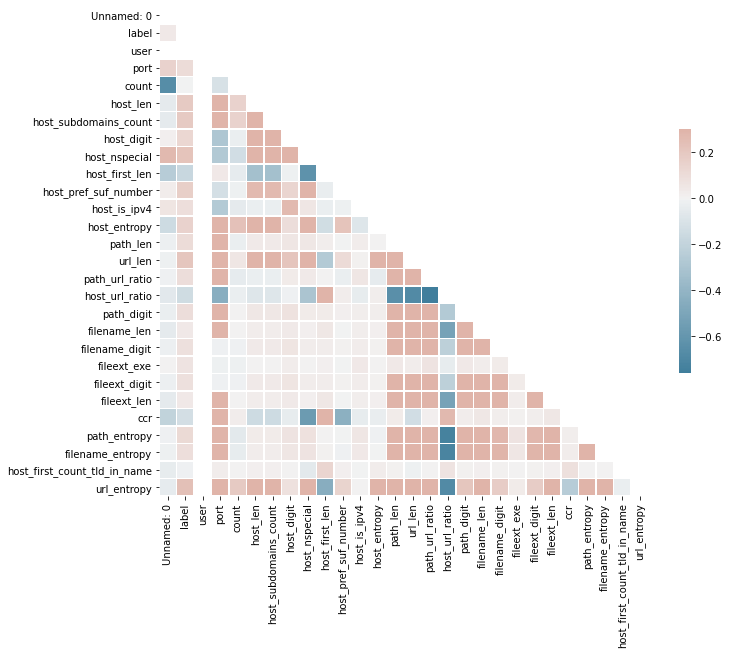

In [38]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Przygotowanie danych 

In [47]:
df['label'].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

`label` to kategoria, którą będziemy przewidywać. Powyższy kod zlicza ile poszczególnych kategorii występuje w danej kolumnie. W tym przypadku problem jest __niezbalansowany__ tj. pewne klasy występują częściej niż inne. Tutaj `0 - dobry link` występuje znacznie częściej niż `1 - zły link`. Z tego powodu wymagane będzie ich __zbalansowanie__. Do balansowania klas wykorzystuje się najczęściej dwie metody (są też inne np. [Tomek(T-Links)](https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/):
- Upsampling - stworzymy więcej próbek dla klas, które są mniejsze np. duplikując część z nich
- Downsampling - wybierzemy losowo próbę z największych klas, która będzie równie liczna jak klasy mniejsze

W tym przypadku wybrałem downsampling, ponieważ bardziej zależy mi na przewidywaniu klasy mniej licznej. W ten sposób, dane z niej nie zostaną powielone i łatwiej będzie odczytać raport z klasyfikacji.

### Downsampling

In [48]:
from sklearn.utils import resample
# Oddzielam klasy
df_majority = df[df.label==0]
df_minority = df[df.label==1]
 
# Wybieram losową próbę z większej z klas
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # Bez powtarzania
                                 n_samples=len(df_minority), # O liczności mniejszej z klas
                                 random_state=123) # Ustawiam aby wyniki były powtarzalne
 
# Łączę obie klasy
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Wyświetlam ilość próbek w każdej z klas
df_downsampled.label.value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [36]:
X, y = df_downsampled.iloc[:,13:].to_numpy(), df_downsampled.loc[:, "label"].astype("int").to_numpy()

In [39]:
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

print(sklearn.metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79     58259
           1       0.76      0.92      0.83     58259

    accuracy                           0.82    116518
   macro avg       0.83      0.82      0.81    116518
weighted avg       0.83      0.82      0.81    116518



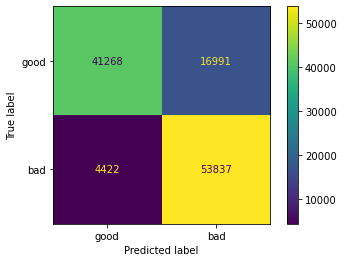

In [41]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["good", "bad"])
disp.plot() 

# AutoML

In [71]:
sum(y_train), len(y_train)

(1294353, 2588707)

In [74]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    tmp_folder='/tmp/autosklearn_classification_example_tmp5',
    memory_limit=16000
)

In [75]:
automl.fit(X_train, y_train)

AutoSklearnClassifier(memory_limit=16000, per_run_time_limit=30,
                      time_left_for_this_task=300,
                      tmp_folder='/tmp/autosklearn_classification_example_tmp5')

In [53]:
automl.show_models()

"[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'sgd', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'select_percentile_classification', 'classifier:sgd:alpha': 1.6992296128865824e-07, 'classifier:sgd:average': 'True', 'classifier:sgd:fit_intercept': 'True', 'classifier:sgd:learning_rate': 'optimal', 'classifier:sgd:loss': 'log', 'classifier:sgd:penalty': 'l1', 'classifier:sgd:tol': 1.535384699341134e-05, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.24471105740962484, 'feature_preprocessor:select_percentile_classification:percentile': 3

In [76]:
automl.leaderboard()

KeyError: 1

In [77]:
predictions = automl.predict(X_test)

In [78]:
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.49999942056059604


In [79]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 6532eaaa-0812-11ec-be43-089798b1040a
  Metric: accuracy
  Number of target algorithm runs: 9
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0

